In [1]:
%cd /home/tk/repos/erc/

/home/tk/repos/erc


In [2]:
ROOT_DIR = './multimodal-datasets/'
# model_checkpoint= '/home/tk/repos/erc/results/MELD/roberta-large/SEEDS/2021-05-08-19-57-31-speaker_mode-upper-num_past_utterances-1000-num_future_utterances-1000-batch_size-4-seed-4/checkpoint-9992/'
# model_checkpoint = '/home/tk/repos/erc/results/IEMOCAP/roberta-large/SEEDS/2021-05-08-16-15-19-speaker_mode-upper-num_past_utterances-1000-num_future_utterances-1000-batch_size-4-seed-2/checkpoint-5975/'
model_checkpoint = '/home/tk/repos/erc/results/IEMOCAP/roberta-large/SEEDS/2021-05-09-12-19-54-speaker_mode-upper-num_past_utterances-1000-num_future_utterances-0-batch_size-4-seed-4/checkpoint-5975/'

DATASET = model_checkpoint.split('/')[6]
params = model_checkpoint.split('/')[9]
speaker_mode = params.split('-')[7]
num_past_utterances = int(params.split('-')[9])
num_future_utterances = int(params.split('-')[11])
SEED = int(params.split('-')[-1])

DATASET, speaker_mode, num_past_utterances, num_future_utterances, SEED

('IEMOCAP', 'upper', 1000, 0, 4)

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils import get_num_classes, ErcTextDataset
import numpy as np
import matplotlib.pyplot as plt
NUM_CLASSES = get_num_classes(DATASET)
tokenizer = AutoTokenizer.from_pretrained(
    model_checkpoint, use_fast=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=NUM_CLASSES)

model.eval()
model.cpu()
ds_test = ErcTextDataset(DATASET=DATASET, SPLIT='test', speaker_mode=speaker_mode,
                         num_past_utterances=num_past_utterances, num_future_utterances=num_future_utterances,
                         model_checkpoint='roberta-large',
                         ROOT_DIR=ROOT_DIR, SEED=SEED)

# ds_train = ErcTextDataset(DATASET=DATASET, SPLIT='train', speaker_mode=speaker_mode,
#                          num_past_utterances=num_past_utterances, num_future_utterances=num_future_utterances,
#                          model_checkpoint='roberta-large',
#                          ROOT_DIR=ROOT_DIR, SEED=SEED)

# ds_val = ErcTextDataset(DATASET=DATASET, SPLIT='val', speaker_mode=speaker_mode,
#                          num_past_utterances=num_past_utterances, num_future_utterances=num_future_utterances,
#                          model_checkpoint='roberta-large',
#                          ROOT_DIR=ROOT_DIR, SEED=SEED)

2021-05-15 13:17:54.479 INFO utils - _load_utterance_ordered: every text file exists fine!
2021-05-15 13:17:54.480 INFO utils - _string2tokens: converting utterances into tokens ...
2021-05-15 13:17:54.482 INFO utils - _string2tokens: creating input utterance data ... 
100%|██████████| 31/31 [00:01<00:00, 17.55it/s]
2021-05-15 13:17:58.716 INFO utils - _create_input: number of truncated utterances: 1131


In [7]:
foo = model.get_input_embeddings()

In [21]:
import torch

In [31]:
foo.training

False

In [30]:
foo(torch.tensor([1]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<EmbeddingBackward>)

In [4]:
def get_random_sample(ds_test, tokenizer, idx=None, max_tokens=512):
    while True:
        if idx is None:
            idx_ = np.random.randint(0, len(ds_test))
        random_sample = ds_test[idx_]
        input_ids, attention_mask, labelid = random_sample['input_ids'], random_sample['attention_mask'], random_sample['label']
        if len(input_ids) < max_tokens and labelid != 0:
            break

    decoded = tokenizer.decode(input_ids)

    input_ids = torch.tensor(input_ids).view(-1, len(input_ids))
    attention_mask = torch.tensor(attention_mask).view(-1, len(attention_mask))
    labelid = torch.tensor(labelid).view(-1, 1)
    

    return idx_, input_ids, attention_mask, labelid, decoded

def return_coeffs(tokenizer, input_ids, attentions, BATCH_IDX=0, LAYER=-1, QUERY_TOKEN_IDX=0, annoying_char='Ġ'):
    tokens = tokenizer.convert_ids_to_tokens(input_ids[BATCH_IDX].tolist())
    QUERY_TOKEN = tokens[QUERY_TOKEN_IDX].split(annoying_char)[-1]

    coeffs = attentions[LAYER][BATCH_IDX].cpu().detach().numpy().sum(axis=0)[QUERY_TOKEN_IDX]
    coeffs /= coeffs.sum()
    
    idx_token_coeffs = [(idx, token.split(annoying_char)[-1], coeffs[idx]) for idx, token in enumerate(tokens)]
    
    assert len(coeffs) == len(tokens) == len(idx_token_coeffs)
    
    
    return QUERY_TOKEN, coeffs, tokens, idx_token_coeffs


In [5]:
import pprint
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

idx, input_ids, attention_mask, labelid, decoded = get_random_sample(ds_test, tokenizer, max_tokens=512)
pprint.pprint(f"{decoded}")
print()

outputs = model(**{'input_ids': input_ids, 'attention_mask': attention_mask}, labels=labelid, output_attentions=True, output_hidden_states=True)
attentions = outputs.attentions
pred = int(outputs.logits.argmax().numpy())
truth = int(labelid[0][0].numpy())

pprint.pprint(f"data_idx: {idx}")
pprint.pprint(f"pred: {ds_test.id2emotion[pred]}")
pprint.pprint(f"truth: {ds_test.id2emotion[truth]}")
pprint.pprint(f"number of tokens in the input: {input_ids.shape[1]}")
print()

('<s>ELIZABETH: Okay, so big news. WILLIAM: What? WILLIAM: Come on, what? '
 "ELIZABETH: I'm getting married. WILLIAM: Shut up. ELIZABETH: Yeah. WILLIAM: "
 'No way. ELIZABETH: Yeah. WILLIAM: He asked you? ELIZABETH: Uh-huh. WILLIAM: '
 'No way, when? when,when, When did it happen? ELIZABETH: Just a couple days '
 'ago. WILLIAM: Oh my gosh. ELIZABETH: [LAUGHTER] WILLIAM: And you actually '
 "said yes.  I can't believe it.  I never thought you would get married. "
 'ELIZABETH: I know me neither. WILLIAM: Oh my gosh. ELIZABETH: Right, I '
 'thought I would be way older too. I thought I would be I be at least thirty '
 "something. WILLIAM: Oh absolutely. WILLIAM: Well, we always said we'd be in "
 'our thirtieth when we got married. And we were going to get married to each '
 "other if we didn't by then ELIZABETH: Yeah. ELIZABETH: I know, right. What'd "
 "we say, when we were thirty nine? WILLIAM: Thirty nine, yeah.  I can't "
 'believe it.  So you broke our pact. Thanks a lot. ELIZABETH

In [21]:
outputs.hidden_states[-1][:, 0, :].shape

torch.Size([1, 1024])

In [12]:
[foo.shape for foo in outputs.hidden_states], [foo.shape for foo in attentions]

([torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024]),
  torch.Size([1, 352, 1024])],
 [torch.Size([1, 16, 352, 352]),
  torch.Size([1, 16, 352, 352]),
  torch.Size([1, 16, 352, 352]),
  torch.Size([1, 16, 352, 352]),
  torch.Size([1, 16, 352, 352]),
  torch.Size([1, 16, 352, 352]),
  torch.Size([1, 16, 352, 352]),
  torch.Size([1, 1

In [6]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [132]:
decoded

"<s>WILLIAM: Okay, what flight were you on? ELIZABETH: Um-Seventeen. Coming from -- WILLIAM: On what airline? ELIZABETH: It was Virgin Atlantic coming from London. WILLIAM: From London, okay. Um- And you went through all your proper checkpoints? ELIZABETH: Yeah, I don't know where it was lost.  I was coming from Africa, so. WILLIAM: So you haven't seen your bags since Africa. You flew threw Heath Row to here. ELIZABETH: Right. ELIZABETH: Yeah. WILLIAM: Okay.  Well, let me see here. I- WILLIAM: It seems like it went through Heath Row.  I see it here. uh- ELIZABETH: That's good. WILLIAM: But uh- I don't see it here in the airport yet. uh WILLIAM: I'm not sure where it is.  We can absolutely keep an eye out for for it for you. ELIZABETH: Well, I can't leave without it. I mean, Could you find out? WILLIAM: Well, I'm not a miracle worker.  I don't know what I can do for you.  I don't have the bag right here. ELIZABETH: Right, well can you get on the computer maybe and like track it down and

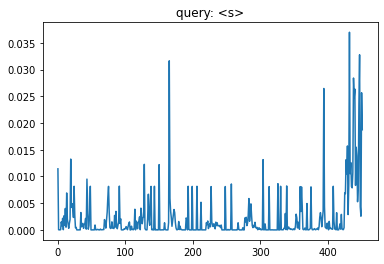

[(0, '<s>', 0.0114284875), (1, 'W', 3.4979177e-05), (2, 'ILL', 1.3367782e-05), (3, 'I', 7.0174897e-06), (4, 'AM', 4.5735174e-05), (5, ':', 0.0015068856), (6, 'Okay', 0.0007700508), (7, ',', 0.0021707455), (8, 'what', 3.969482e-05), (9, 'flight', 0.0026371763), (10, 'were', 0.00089242065), (11, 'you', 0.0040123826), (12, 'on', 0.0005166852), (13, '?', 0.0069143265), (14, 'EL', 0.002006569), (15, 'IZ', 0.0012009309), (16, 'AB', 0.00029409843), (17, 'ETH', 0.0012271301), (18, ':', 0.0019554114), (19, 'Um', 0.013253212), (20, '-', 0.0042030434), (21, 'Se', 0.0049087554), (22, 'vent', 0.003974822), (23, 'een', 0.002330458), (24, '.', 0.008163634), (25, 'Coming', 0.0026792304), (26, 'from', 0.0003968156), (27, '--', 0.0004825021), (28, 'WILL', 3.3295578e-06), (29, 'I', 1.011884e-06), (30, 'AM', 1.4858676e-06), (31, ':', 4.8981988e-06), (32, 'On', 1.688588e-05), (33, 'what', 1.5103317e-06), (34, 'airline', 0.003253574), (35, '?', 0.0005747816), (36, 'EL', 0.0011380491), (37, 'IZ', 0.001214321

In [133]:
QUERY_TOKEN, coeffs, tokens, idx_token_coeffs = return_coeffs(tokenizer, input_ids, attentions, LAYER=-1, QUERY_TOKEN_IDX=0)

plt.figure()
plt.plot(coeffs);
plt.title(f'query: {QUERY_TOKEN}')
plt.show()

print(idx_token_coeffs)
print()

top_10 = sorted(idx_token_coeffs, key=lambda x:-x[2])[:10]
print(top_10)

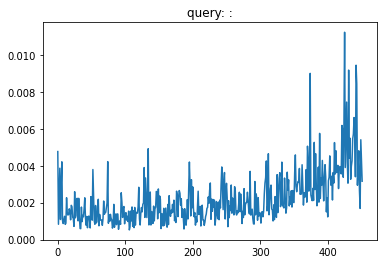

[(0, '<s>', 0.004766664), (1, 'W', 0.0008292274), (2, 'ILL', 0.0023149499), (3, 'I', 0.0038646723), (4, 'AM', 0.0010866254), (5, ':', 0.0029311024), (6, 'Okay', 0.0042115226), (7, ',', 0.0010148187), (8, 'what', 0.000868007), (9, 'flight', 0.0010547405), (10, 'were', 0.0012607038), (11, 'you', 0.0008247578), (12, 'on', 0.0008841172), (13, '?', 0.0022653206), (14, 'EL', 0.0014489166), (15, 'IZ', 0.0013281829), (16, 'AB', 0.0013601274), (17, 'ETH', 0.0016657041), (18, ':', 0.0014974325), (19, 'Um', 0.0010708463), (20, '-', 0.0018548773), (21, 'Se', 0.0017793649), (22, 'vent', 0.001214499), (23, 'een', 0.0011445653), (24, '.', 0.00071424374), (25, 'Coming', 0.0025916095), (26, 'from', 0.0011751319), (27, '--', 0.0013064704), (28, 'WILL', 0.0022192406), (29, 'I', 0.002229674), (30, 'AM', 0.0010143179), (31, ':', 0.002234183), (32, 'On', 0.0012354917), (33, 'what', 0.0006006622), (34, 'airline', 0.00059050444), (35, '?', 0.0017600234), (36, 'EL', 0.00097046746), (37, 'IZ', 0.0013092053), (3

In [138]:
QUERY_TOKEN, coeffs, tokens, idx_token_coeffs = return_coeffs(tokenizer, input_ids, attentions, LAYER=0, QUERY_TOKEN_IDX=438)

plt.figure()
plt.plot(coeffs);
plt.title(f'query: {QUERY_TOKEN}')
plt.show()

print(idx_token_coeffs)
print()

top_10 = sorted(idx_token_coeffs, key=lambda x:-x[2])[:10]
print(top_10)